# Methane Pyrolysis

The following notebook runs a simple analysis of a methane pyrolysis experiment conducted using a TGA. The catalyst material is first reduced under hydrogen atmosphere, and used to convert Methane to a carbon material and hydrogen at elevated temperature. By following the weight increase of the sample, the reaction kinetics can be studied.

In [1]:
import pyTGA as tga
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Loading the data

In the quickplot we can clearly see the weight increase due to carbon buildup on the catalyst.

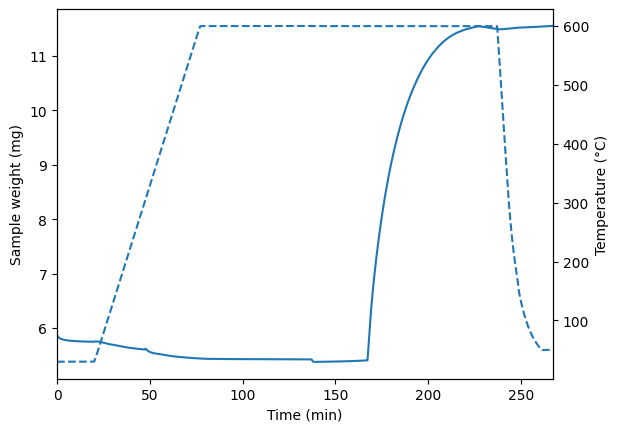

In [2]:
#loading the data
import os
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'example_data'))
tga_exp = tga.parse_PE(os.path.join(data_dir, 'Methane_Pyrolysis.txt'))
#quickplot to look at the whole experiment
tga_exp.quickplot()


## Pre-processing
We first extract the weight of the catalyst material, then isolate the section of data that contains the actual methane pyrolysis experiment. To determine the mass of carbon formed, we subtract the first weight at the start of the stage. We then calculate a derivative to determine the rate.

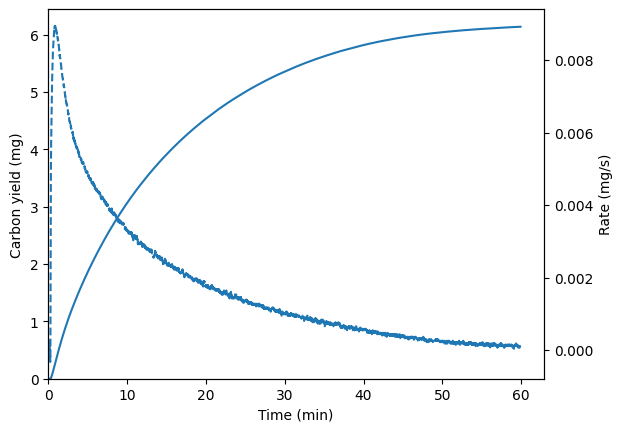

In [3]:
mass_catalyst = tga_exp.get_stage('stage1')['Unsubtracted weight'].min()
mass_catalyst_reduced = tga_exp.get_stage('stage2')['Unsubtracted weight'].min()
cracking_stage = 'stage6'

data = tga_exp.get_stage(cracking_stage)
data['Carbon yield'] = data['Unsubtracted weight'] - data['Unsubtracted weight'].iloc[0]
data['Pyrolysis time'] = data['Time'] - data['Time'].iloc[0]

#rate, deviding by 60 to convert from minutes to seconds
data['Rate'] = data['Carbon yield'].diff() / data['Pyrolysis time'].diff() / 60

#plotting
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(data['Pyrolysis time'], data['Carbon yield'], label='Carbon yield')
ax2.plot(data['Pyrolysis time'], data['Rate'], label='Rate', linestyle='--', )

ax.set_xlim(0,)
ax.set_ylim(0,)
ax.set_xlabel('Time ({})'.format(tga_exp.time_unit))
ax.set_ylabel('Carbon yield (mg)')
ax2.set_ylabel('Rate ({}/s)'.format(tga_exp.weight_unit))
plt.show()

## Fitting

To extract kinetic parameters, we fit the following equation:
\begin{equation}
r(t) = \frac{1}{\left[1 + (d - 1)r_d t\right]^{\frac{1}{d-1}}} \cdot r_0
\end{equation}

Where $r(t)$ is the rate of carbon formation at time $t$, $r_0$ the initial rate, d a deactivation factor, and $r_d$ the rate of deactivation.
For the fit, we calcualte the rate in units of the mass of the reduced catalyst and discard the datapoints before reaching the maximum. 


Fitted parameters:
r0: 0.0016 ± 0.0000 (1/s) 
rd: 0.1214 ± 0.0009 
d: 1.3940 ± 0.0055


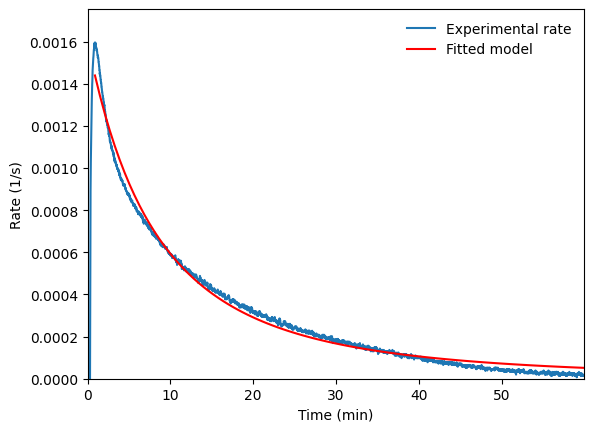

In [ ]:
data['Rate_corr'] = data['Rate']/mass_catalyst_reduced  
data_fit = data.iloc[data['Rate'].idxmax():].copy()

from scipy.optimize import curve_fit
def model(t, r0, rd, d):
    return r0 / ((1 + (d - 1) * rd * t) ** (1 / (d - 1)))

initial_guess = [0.009, 0.11647663, 1.39403578]
popt, pcov = curve_fit(model, data_fit['Pyrolysis time'], data_fit['Rate_corr'], p0=initial_guess, maxfev=10000)

output_dict = {
    'r0': popt[0],
    'rd': popt[1],
    'd': popt[2]
}
errors = {
    'r0': np.sqrt(np.diag(pcov))[0],
    'rd': np.sqrt(np.diag(pcov))[1],
    'd': np.sqrt(np.diag(pcov))[2]
}

print('Fitted parameters:'
      '\nr0: {:.4f} ± {:.4f} ({})'.format(output_dict['r0'], errors['r0'], '1/s'),
      '\nrd: {:.4f} ± {:.4f}'.format(output_dict['rd'], errors['rd']),
      '\nd: {:.4f} ± {:.4f}'.format(output_dict['d'], errors['d']))

# Plotting the fitted model
t_fit = np.linspace(data_fit['Pyrolysis time'].min(), data_fit['Pyrolysis time'].max(), 100)
r_fit = model(t_fit, *popt)

fig, ax = plt.subplots()
ax.plot(data['Pyrolysis time'], data['Rate_corr'], label='Experimental rate')
ax.plot(t_fit, r_fit, label='Fitted model', color='red')
ax.set_xlabel('Time ({})'.format(tga_exp.time_unit))
ax.set_ylabel('Rate (1/s)')
ax.legend(frameon=False)
ax.set_xlim(0, data['Pyrolysis time'].max())
ax.set_ylim(0, data['Rate_corr'].max() * 1.1)
plt.show()
